# Run Test-Time Simulation with Multiple Reward Model

In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import yaml 
import json

In [2]:
'---- Load the computed reward scores of each prompt, each image and each timestep ---'
value_folder = 'values'
diffusion_model = 'flux' # flux or sdxl
reward_models = ['imr', 'pic', 'hps'] # imr or pic or hps
num_prompt = 200 # number of prompts to use
num_image = 200 # number of images per prompt
num_steps = 20 # number of diffusion inference timesteps

def load_reward_values(value_folder, diffusion_model, reward_model, num_prompt, num_image, num_steps):
    reward_base_all = []  # shape (num_prompt, num_image, num_steps)
    reward_naft_all = [] # shape (num_prompt, num_image, num_steps)

    location_base = f'{value_folder}/{diffusion_model}_{reward_model}_val_base'
    for s in np.arange(num_steps):
        file_name = f'p{num_prompt}_i{num_image}_s{s:02d}.yaml'
        r_dict = yaml.safe_load(open(f'{location_base}/{file_name}')) 
        reward_one_step = np.stack([r_dict[k] for k in sorted(r_dict.keys())], axis=0) # shape (num_prompt, num_image)
        reward_base_all.append(reward_one_step)
    reward_base_all = np.stack(reward_base_all, axis=-1) # shape (num_prompt, num_image, num_steps)
    print(f'Loaded base reward scores of {reward_model} with shape: {reward_base_all.shape}')

    location_naft = f'{value_folder}/{diffusion_model}_{reward_model}_val_naft'
    for s in np.arange(num_steps):
        file_name = f'p{num_prompt}_i{num_image}_s{s:02d}.yaml'
        if not os.path.exists(f'{location_naft}/{file_name}'):
            # some steps are not used for naft and we use base values instead, e.g. steps too high or too low
            r_dict = yaml.safe_load(open(f'{location_base}/{file_name}')) 
        else:
            r_dict = yaml.safe_load(open(f'{location_naft}/{file_name}')) 
        reward_one_step = np.stack([r_dict[k] for k in sorted(r_dict.keys())], axis=0) # shape (num_prompt, num_image)
        reward_naft_all.append(reward_one_step)
    reward_naft_all = np.stack(reward_naft_all, axis=-1) # shape (num_prompt, num_image, num_steps)

    print(f'Loaded naft reward scores of {reward_model} with shape: {reward_naft_all.shape}')
    return reward_base_all, reward_naft_all


reward_base_all_ = []
reward_naft_all_ = []
for reward_model in reward_models:
    reward_base_all, reward_naft_all = load_reward_values(
        value_folder, diffusion_model, reward_model, num_prompt, num_image, num_steps
    )
    reward_base_all_.append(reward_base_all)
    reward_naft_all_.append(reward_naft_all)

reward_base_all = np.stack(reward_base_all_, axis=-1) # shape (num_prompt, num_image, num_steps, num_reward_models)
reward_naft_all = np.stack(reward_naft_all_, axis=-1) # shape (num_prompt, num_image, num_steps, num_reward_models)
print(f'Final base reward scores shape: {reward_base_all.shape}')
print(f'Final naft reward scores shape: {reward_naft_all.shape}')
    

Loaded base reward scores with shape: (200, 200, 20)
Loaded naft reward scores with shape: (200, 200, 20)
Loaded base reward scores with shape: (200, 200, 20)
Loaded naft reward scores with shape: (200, 200, 20)
Loaded base reward scores with shape: (200, 200, 20)
Loaded naft reward scores with shape: (200, 200, 20)
Final base reward scores shape: (200, 200, 20, 3)
Final naft reward scores shape: (200, 200, 20, 3)


In [19]:
import numpy as np

def random_mask(n, m):
    assert n >= m 
    mask = np.full(n, False, dtype=bool)
    true_indices = np.random.choice(n, size=m, replace=False)
    mask[true_indices] = True
    return mask


class Simulation():
    def __init__(self, x, y, max_step=20):
        self.x = x # the denoise budget (TFlops)
        self.y = y # the verifier budget (TFlops)
        self.max_step = max_step
    
    # ----- The TTS Best of N selection baseline -----
    def bon(self, r_gt):
        # r_gt: [num_prompts * num_images]
        return r_gt.max(axis=1).mean().item(), r_gt.argmax(axis=1) 
        
    def bon_cost(self):
        # of one image selection
        return self.max_step * self.x + self.y

    def bon_multi(self, r_gt):
        n_p, n_i, n_obj = r_gt.shape
        # argsort() gives the order, the second argsort() gives the rank position
        ranks = r_gt.argsort(axis=1).argsort(axis=1) # [n_p, n_i, n_obj]   
        rank_sum = ranks.sum(axis=2) # [n_p, n_i]
        max_ids = rank_sum.argmax(axis=1) # [n_p]
        best_rewards = r_gt[np.arange(n_p), max_ids] # [n_p, n_obj]        
        return best_rewards.mean(axis=0), max_ids

    def bon_run(self, r_gt, image_num_use, iters=10, use_multi=False):
        # r_gt: [num_prompts * num_images(all)] 
        # if use_multi is True, r_gt: [num_prompts, num_images(all), num_objectives]
        out_rewards = []
        image_num_all = r_gt.shape[1]
        # run mutliple iters for averaging
        for i in range(iters):
            mask = random_mask(image_num_all, image_num_use)
            if use_multi:
                r_gt_select = r_gt[:, mask, :]
                out_reward, out_ids = self.bon_multi(r_gt_select)
            else:
                r_gt_select = r_gt[:, mask]
                out_reward, out_ids = self.bon(r_gt_select)
            out_rewards.append(out_reward)
        if iters == 1:
            return out_reward, out_ids
        else:
            return np.mean(out_rewards, axis=0), None
    


    # ----- The TTSp / TTSnap selection -----
    # steps use : list of steps to use (exclude the final step, which is gt, starting from 0)
    # alpha_s: list of alphas to use 
    # r: [num_prompts , num_images, num_steps]  

    def ttsp(self, r, alpha_s, steps_use):
        n_p, n_i, n_s = r.shape # num_prompts, num_images, num_steps
        # pruning at each timestepw
        mask = np.full((n_p, n_i), True, dtype=bool) # [n_p, n_i]
        image_ids = np.tile(np.arange(n_i), (n_p, 1)) # [n_p, n_i]
        for i, step in enumerate(steps_use): 
            r_mid = r[:, :, step][mask].reshape(n_p, -1) # [n_p, current_num_images]
            topn = max(1, round(r_mid.shape[1] * alpha_s[i]))
            
            # thresholds = np.partition(r_mid, -topn, axis=1)[:, -topn][:, None] # [n_p, 1] # threshold for top n selection
            # mask = mask & (r_mid_all >= thresholds) # [n_p, n_i] # update
            # image_ids = image_ids[r_mid >= thresholds].reshape(n_p, -1) # [n_p, rest_num_images]

            top_idx_in_rmid = np.argpartition(r_mid, -topn, axis=1)[:, -topn:]
            # update the image ids
            rows = np.arange(n_p)[:, None]
            image_ids = image_ids[rows, top_idx_in_rmid] # [n_p, topn]
            # update the global mask
            new_sub_mask = np.zeros_like(r_mid, dtype=bool)
            new_sub_mask[rows, top_idx_in_rmid] = True
            mask[mask.copy()] = new_sub_mask.ravel()
            
        # final timestep selection
        r_gt = r[:, :, -1][mask].reshape(n_p, -1) # [n_p, current_num_images]
        max_values = r_gt.max(axis=1) # [n_p]
        max_ids = image_ids[np.arange(n_p),r_gt.argmax(axis=1)] # [n_p] 
        return max_values.mean().item(), max_ids
            
    def ttsp_cost(self, alpha_s, steps_use):
        # of one image selection
        cost = 0 
        alpha_cum = 1 
        prev_step = 0 
        for j, s in enumerate(steps_use):
            cost += alpha_cum * ((s - prev_step) * self.x + self.y)
            alpha_cum *= alpha_s[j]
            prev_step = s
        cost += alpha_cum * ((self.max_step - 1 - prev_step) * self.x + self.y)
        return cost 
    
    def ttsp_multi(self, r, alpha_s, steps_use):
        n_p, n_i, n_s, n_obj = r.shape # num_prompts, num_images, num_steps, num_objectives
        mask = np.full((n_p, n_i), True, dtype=bool) 
        image_ids = np.tile(np.arange(n_i), (n_p, 1))

        for i, step in enumerate(steps_use):
            r_mid = r[:, :, step, :] # [n_p, current_num_images, n_obj]
            r_mid_multi = r_mid[mask].reshape(n_p, -1, n_obj) # [n_p, current_num_images, n_obj]

            ranks = r_mid_multi.argsort(axis=1).argsort(axis=1)  # [n_p, current_num_images, n_obj]

            r_mid_combined = ranks.sum(axis=2)  # [n_p, current_num_images]

            topn = max(1, round(r_mid_combined.shape[1] * alpha_s[i]))
            top_idx_in_rmid = np.argpartition(r_mid_combined, -topn, axis=1)[:, -topn:]

            # update the image ids
            rows = np.arange(n_p)[:, None]
            image_ids = image_ids[rows, top_idx_in_rmid] # [n_p, topn]
            # update the global mask
            new_sub_mask = np.zeros_like(r_mid_combined, dtype=bool)
            new_sub_mask[rows, top_idx_in_rmid] = True
            mask[mask.copy()] = new_sub_mask.ravel()
        
        # final timestep selection
        r_gt = r[:, :, -1, :][mask].reshape(n_p, -1, n_obj) # [n_p, current_num_images, n_obj]
        final_ranks = r_gt.argsort(axis=1).argsort(axis=1).sum(axis=-1) # [n_p, current_num_images]
        best_inner_idx = final_ranks.argmax(axis=1) # [n_p]
        max_ids = image_ids[np.arange(n_p), best_inner_idx] # [n_p]
        avg_reward = r_gt[np.arange(n_p), best_inner_idx].mean(axis=0) # [n_obj]
        return avg_reward, max_ids

    def ttsp_run(self, r, image_num_use, alpha_s, steps_use, iters=10, use_multi=False):
        assert (steps_use==np.sort(steps_use)).all(), "Steps must be in ascending order."
        assert len(alpha_s) == len(steps_use), "Length of alpha_s and steps_use must match."
        image_num_all = r.shape[1]
        out_rewards = []
        for i in range(iters):
            mask = random_mask(image_num_all, image_num_use)
            if use_multi:
                r_select = r[:, mask, :, :]
                out_reward, out_ids = self.ttsp_multi(r_select, alpha_s, steps_use)
            else:
                r_select = r[:, mask, :]
                out_reward, out_ids = self.ttsp(r_select, alpha_s, steps_use)
            out_rewards.append(out_reward)
        if iters == 1:
            return out_reward, out_ids
        else:
            return np.mean(out_rewards, axis=0), None

In [16]:
'Compare TTSnap, TTSp and Best-of-N'

denoise_budget = 9.9 # TFlops
verifier_budget = 1.2 # TFlops

budget = 2000 
iters = 40

S = Simulation(x=denoise_budget, y=verifier_budget, max_step=num_steps)

# Best-of-N
n = int(budget / S.bon_cost())
print('Number of images seen in Best-of-N:', n)
r_bon, _ = S.bon_run(reward_base_all[:,:,-1, :], image_num_use=n, iters=iters, use_multi=True)

# TTsnap
alphas = [0.4, 0.4, 0.5] # hyperparameters
steps_use = [2, 6, 11] # hyperparameters
n = int(budget / S.ttsp_cost(alpha_s=alphas, steps_use=steps_use))
print('Number of images seen in TTsnap:', n)
r_ttsp, _ = S.ttsp_run(reward_naft_all, image_num_use=n, alpha_s=alphas, 
        steps_use=steps_use, iters=iters, use_multi=True)

print('Averaged reward Best-of-N of all the prompts:', r_bon)
print('Averaged reward TTsnap of all the prompts:', r_ttsp)

Number of images seen in Best-of-N: 10
Number of images seen in TTsnap: 38
Averaged reward Best-of-N of all the prompts: [ 1.49661437 21.98842187  0.28836693]
Averaged reward TTsnap of all the prompts: [ 1.53964418 22.13973381  0.29064779]


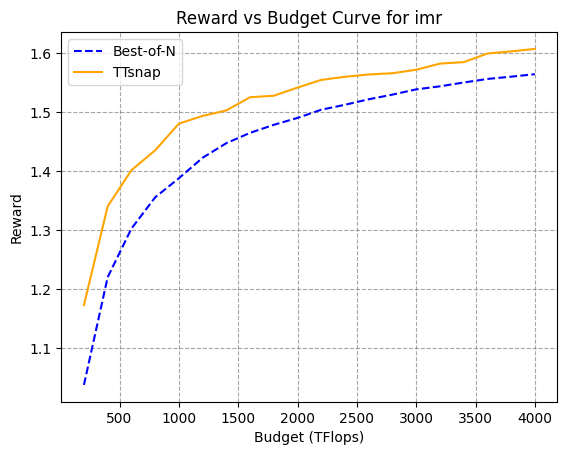

relative increase: 14.23%


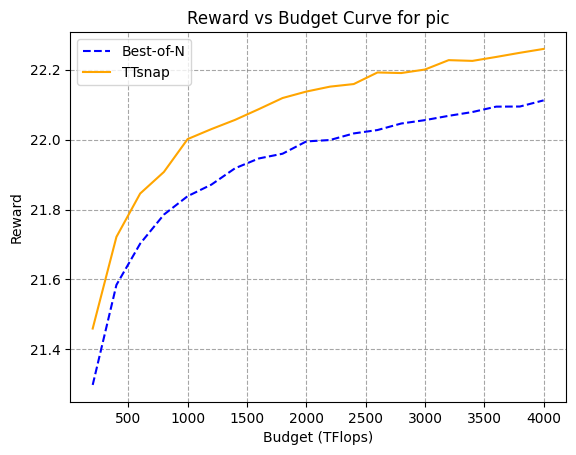

relative increase: 22.89%


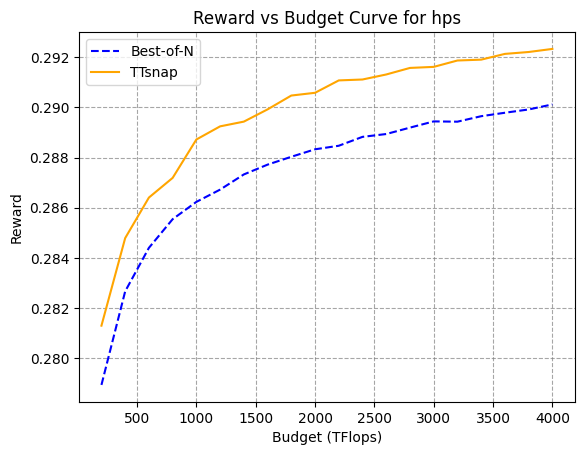

relative increase: 25.95%


In [24]:
'Plot and evaluation under different budgets settings'
from scipy import integrate
from matplotlib import pyplot as plt

denoise_budget = 9.9 # TFlops
verifier_budget = 1.2 # TFlops

budget_start = 200 
budget_end = 4000 
iters = 40

S = Simulation(x=denoise_budget, y=verifier_budget, max_step=num_steps)

results_bon = []
results_ttsp = []
for budget in range(budget_start, budget_end+1, 200):
    # Best-of-N
    n = int(budget / S.bon_cost())
    r_bon, _ = S.bon_run(reward_base_all[:,:,-1,:], image_num_use=n, iters=iters, use_multi=True)
    results_bon.append(r_bon)

    # TTsnap
    alphas = [0.4, 0.4, 0.5] # hyperparameters
    steps_use = [2, 6, 11] # hyperparameters
    n = int(budget / S.ttsp_cost(alpha_s=alphas, steps_use=steps_use))
    r_ttsp, _ = S.ttsp_run(reward_naft_all, image_num_use=n, alpha_s=alphas, 
        steps_use=steps_use, iters=iters, use_multi=True)
    results_ttsp.append(r_ttsp)

results_bon = np.stack(results_bon, axis=0) # shape (num_budgets, num_objectives)
results_ttsp = np.stack(results_ttsp, axis=0) # shape (num_budgets, num_objectives)


# Plot the reward vs budget curves
def plot_curve(budgets, rewards_out1, rewards_out2, label1, label2, reward_name):
    plt.plot(budgets, rewards_out1, label=label1, color='blue', linestyle='--')
    plt.plot(budgets, rewards_out2, label=label2, color='orange')
    plt.xlabel('Budget (TFlops)')
    plt.ylabel('Reward')
    plt.title(f'Reward vs Budget Curve for {reward_name}')
    plt.legend()
    plt.grid(linestyle='--', color='gray', alpha=0.7)
    plt.show()
    plt.close()


def evaluate(budgets, rs, rs_base):
    # rs: PTTS
    # rs_base: TTS
    assert len(budgets) == len(rs) == len(rs_base), "Lengths must match."
    assert (np.arange(len(budgets))==np.argsort(budgets)).all(), "Budgets must be sorted in ascending order."
    y0 = np.array(rs_base)[0]
    y_rs = np.array(rs) - y0
    y_rs_base = np.array(rs_base) - y0
    area1 = integrate.simpson(y=y_rs, x=budgets)
    area2 = integrate.simpson(y=y_rs_base, x=budgets)
    increase = (area1 - area2) / area2 if area2 != 0 else float('inf')
    increase = np.round(100*increase, 2)
    print(f'relative increase: {increase.item()}%')

budgets = list(range(budget_start, budget_end+1, 200))
for i in range(len(reward_models)):
    plot_curve(budgets, results_bon[:,i], results_ttsp[:,i], label1='Best-of-N', label2='TTsnap', reward_name=reward_models[i])
    omega = evaluate(budgets, results_ttsp[:,i], results_bon[:,i])